In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import csv
from tqdm import tqdm
import rasterio

from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import folium

import tifffile
from rasterio.features import rasterize
import seaborn as sns

import tifffile as tiff
from sklearn.metrics import mean_squared_error

import networkx as nx
import osmnx as ox
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
import time

In [3]:
geojson_path = "/data-sat-img/postprocessed/mujiang/master-thesis/poi_geojson/"

save_folder = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/prediction/"
cat_list = ["paper2"]
model_list = ['unet-mwca-resnet50-3classes_dice-berhu-__13-03-2024_1']
epoch_list = ["63epoch"]
i = 0
pred_path = os.path.join(save_folder,cat_list[i],model_list[i],epoch_list[i])

blockraster_path = "/data-sat-img/postprocessed/mujiang/master-thesis/block_raster/"
block_metric_path = "/data-sat-img/postprocessed/mujiang/master-thesis/block_metric/geojson/"
block_metric_gpkg_path = "/data-sat-img/postprocessed/mujiang/master-thesis/block_metric_gpkg/"
planet_folder = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/input/predict/planet"
refer_path = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/input/predict/height/original/"
label_path = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/input/predict/height/cluster-sebastiano-label3/"
temppath = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/temp/basemap-mosaic/"

In [4]:
def plot_GSI_FSI_heatmap(refer_GSI,building_GSI,refer_FSI,building_FSI,GSI_max = 0.8,FSI_max = 15,bin_heat = 15):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Heatmap for GSI
    gsi_x = refer_GSI
    gsi_y = building_GSI
    gsi_heatmap, xedges, yedges = np.histogram2d(gsi_x, gsi_y, bins=bin_heat, range=[[0, GSI_max], [0, GSI_max]])
    gsi_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    axes[0].imshow(gsi_heatmap.T, extent=gsi_extent, origin='lower', aspect='auto', cmap='viridis')
    axes[0].set_xlabel("Reference GSI", fontsize=15)
    axes[0].set_ylabel("Prediction GSI", fontsize=15)
    axes[0].set_title("GSI Compare", fontsize=18)

    # Scatter plot overlay for GSI
    #axes[0].scatter(gsi_x, gsi_y, alpha=0.2, s=10 * block_df_merged["block_area"] / block_df_merged["block_area"].mean())
    x = np.linspace(0, GSI_max, 10)
    y = x
    axes[0].plot(x, y, 'r--', label='y = x')

    # Heatmap for FSI
    fsi_x = refer_FSI
    fsi_y = building_FSI
    fsi_heatmap, xedges, yedges = np.histogram2d(fsi_x, fsi_y, bins=bin_heat, range=[[0, FSI_max], [0, FSI_max]])
    fsi_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    axes[1].imshow(fsi_heatmap.T, extent=fsi_extent, origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_xlabel("Reference FSI", fontsize=15)
    axes[1].set_ylabel("Prediction FSI", fontsize=15)
    axes[1].set_title("FSI Compare", fontsize=18)

    # Scatter plot overlay for FSI
    #axes[1].scatter(fsi_x, fsi_y, alpha=0.2, s=10 * block_df_merged["block_area"] / block_df_merged["block_area"].mean(), c='red')
    x = np.linspace(0, FSI_max, 10)
    y = x
    axes[1].plot(x, y, 'r--', label='y = x')

    plt.show()

## read block metric gdf

In [5]:
block_metric_files = os.listdir(block_metric_path)
block_metric_list = []
pred_city_list = []

for block_metric_file in tqdm(block_metric_files):  
    block_metric_list.append(gpd.read_file(os.path.join(block_metric_path,block_metric_file)))
    pred_city_list.append(block_metric_file.split("_block_metric.geojson")[0])

100%|█████████████████████████████████████████████████████████████████████████████████████████| 40/40 [08:46<00:00, 13.16s/it]


In [6]:
print(pred_city_list)

['Shanghai', 'Guiyang', 'Wuxi', 'Xiamen', 'Shaoxing', 'Shenzhen', 'Harbin', 'Foshan', 'Zhongshan', 'Dongguan', 'Nanchang', 'Baoding', 'Yangzhou', 'Zhuhai', 'Chongqing', 'Chengdu', 'Suzhou', 'Zhengzhou', 'Guangzhou', 'Beijing', 'Taiyuan', 'Sanya', 'Shenyang', 'Tianjin', 'Dalian', 'Huizhou', 'Langfang', 'Fuzhou', 'Xi_an', 'Qingdao', 'Hangzhou', 'Changsha', 'Nanjing', 'Hefei', 'Ningbo', 'Zhenjiang', 'Kunming', 'Xuzhou', 'Nanning', 'Wuhan']


## check RMSE

In [6]:
FSI_mse_list = []
GSI_mse_list = []
FSI_mean_list = []
GSI_mean_list = []
size_list = []

for block_df in block_metric_list:
    block_df_merged = block_df[block_df['refer_GSI'] > 0.05]
    block_df_merged = block_df_merged[block_df_merged["Shape_Area"]>10000]
    refer_year = 2019
    
    if (f'building_{refer_year}_FSI_avg' in list(block_df_merged.columns)) == False:
        refer_year = 2020
           
    mse_fsi = mean_squared_error(block_df_merged['refer_FSI'], block_df_merged[f'building_{refer_year}_FSI_avg'])
    mse_gsi = mean_squared_error(block_df_merged['refer_GSI'], block_df_merged[f'building_{refer_year}_GSI_avg'])
    
    FSI_mse_list.append(mse_fsi)
    GSI_mse_list.append(mse_gsi)
    
    FSI_mean_list.append(block_df_merged[f'building_{refer_year}_FSI_avg'].mean())
    GSI_mean_list.append(block_df_merged[f'building_{refer_year}_GSI_avg'].mean())
    
    size_list.append(block_df_merged.shape[0])
    
block_metric_eval_df = pd.DataFrame({'city': pred_city_list})
block_metric_eval_df["refer_FSI_mse"] = FSI_mse_list
block_metric_eval_df["refer_GSI_mse"] = GSI_mse_list
block_metric_eval_df["pred_FSI_mean"] = FSI_mean_list
block_metric_eval_df["pred_GSI_mean"] = GSI_mean_list
block_metric_eval_df["number_block"] = size_list

In [7]:
block_metric_eval_df.head()

,city,refer_FSI_mse,refer_GSI_mse,pred_FSI_mean,pred_GSI_mean,number_block
0,Shanghai,7.395224,0.014230,5.792357,0.273346,7404
1,Guiyang,26.652823,0.016657,6.001720,0.245105,687
2,Wuxi,6.631050,0.016413,4.643679,0.259334,2923
3,Xiamen,20.523932,0.020430,5.469347,0.292958,1588
4,Shaoxing,9.024876,0.023976,4.892433,0.275513,800


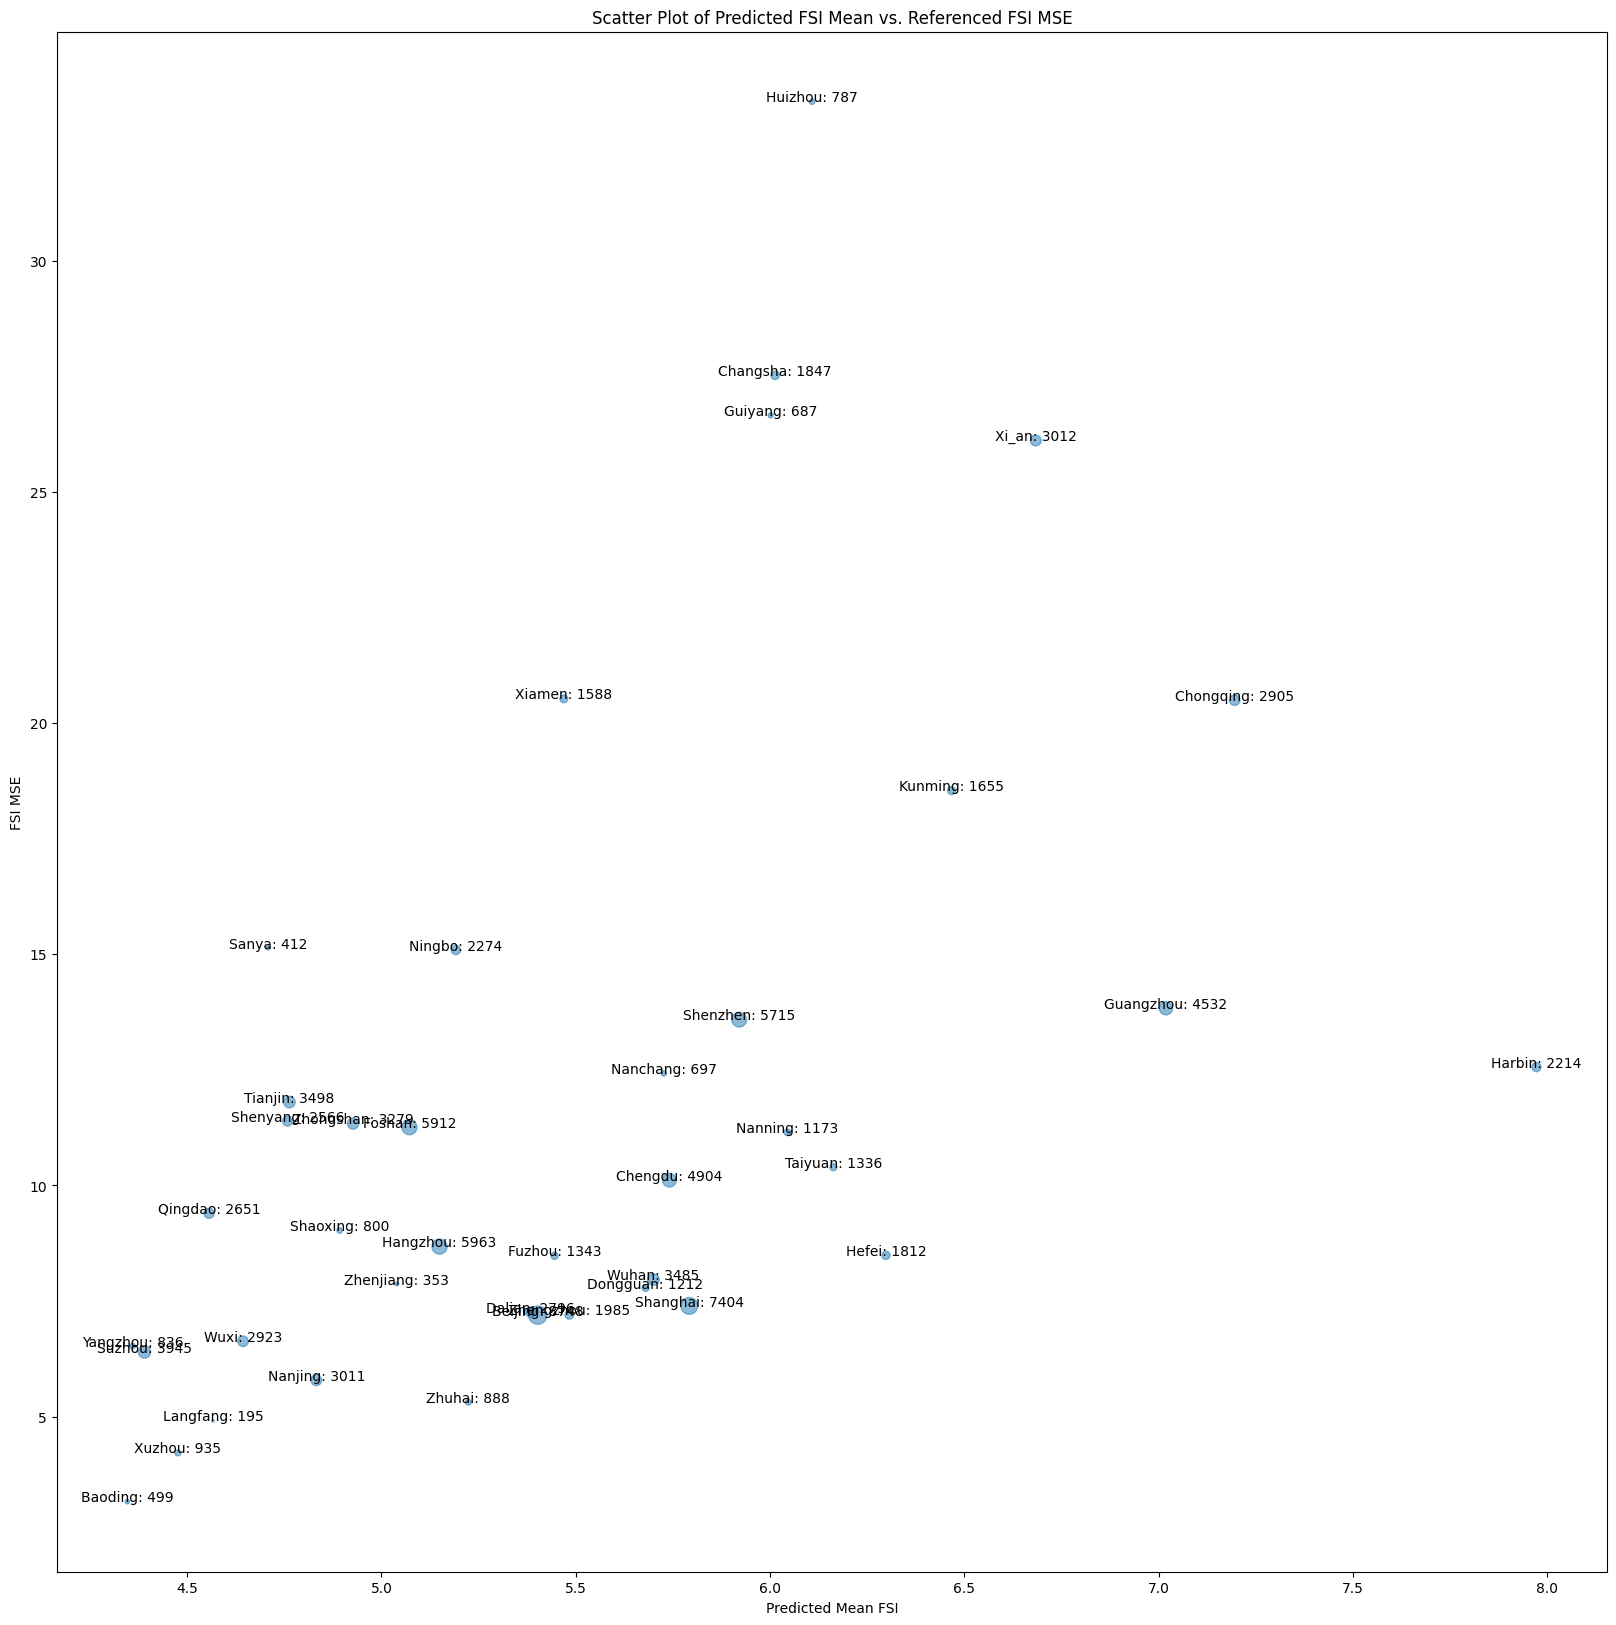

In [8]:
# Create the scatter plot
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
scatter = plt.scatter(
    x=block_metric_eval_df['pred_FSI_mean'],
    y=block_metric_eval_df['refer_FSI_mse'],
    s=block_metric_eval_df['number_block'] / 50,  # Adjust multiplier to scale point sizes appropriately
    alpha=0.5  # Transparency of points
)

# Annotate each point with the city name
for i in range(len(block_metric_eval_df)):
    plt.text(
        x=block_metric_eval_df['pred_FSI_mean'].iloc[i],
        y=block_metric_eval_df['refer_FSI_mse'].iloc[i],
        s=block_metric_eval_df['city'].iloc[i] + ": " + str(block_metric_eval_df['number_block'].iloc[i]),
        fontdict=dict(color='black', size=10),  # Adjust text color and size
        ha='center'  # Horizontal alignment
    )

# Adding labels and title
plt.xlabel('Predicted Mean FSI')
plt.ylabel('FSI MSE')
plt.title('Scatter Plot of Predicted FSI Mean vs. Referenced FSI MSE')

# Show the plot
plt.show()

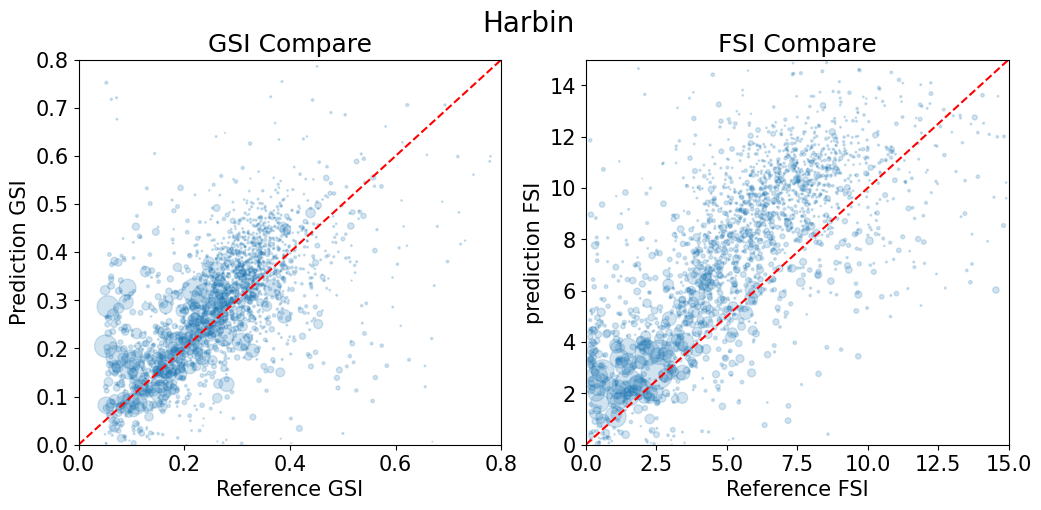

In [9]:
test_city = "Harbin"
GSI_max = 0.8
FSI_max = 15

block_df_merged = block_metric_list[pred_city_list.index(test_city)]
block_df_merged = block_df_merged[block_df_merged["refer_GSI"] > 0.05]
block_df_merged = block_df_merged[block_df_merged["Shape_Area"]>10000]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(block_df_merged.refer_GSI, block_df_merged.building_2019_GSI_avg,alpha = 0.2,s=10*block_df_merged["Shape_Area"]/block_df_merged["Shape_Area"].mean())
axes[0].set_xlabel(f"Reference GSI",fontsize=15)
axes[0].set_ylabel(f"Prediction GSI",fontsize=15)
axes[0].set_xlim(0, GSI_max)
axes[0].set_ylim(0, GSI_max)
axes[0].set_title("GSI Compare",fontsize=18)

axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

x = np.linspace(0, GSI_max, 10)
# Calculate y values for y = x
y = x
axes[0].plot(x, y, 'r--', label='y = x')

axes[1].scatter(block_df_merged.refer_FSI, block_df_merged.building_2019_FSI_avg,alpha = 0.2,s=10*block_df_merged["Shape_Area"]/block_df_merged["Shape_Area"].mean())
axes[1].set_xlabel(f"Reference FSI",fontsize=15)
axes[1].set_ylabel(f"prediction FSI",fontsize=15)
axes[1].set_xlim(0, FSI_max)
axes[1].set_ylim(0, FSI_max)
axes[1].set_title("FSI Compare",fontsize=18)

x = np.linspace(0, FSI_max, 10)
# Calculate y values for y = x
y = x
axes[1].plot(x, y, 'r--', label='y = x')

axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

plt.suptitle(test_city,fontsize=20)

plt.show()


# K-mean block cluster

### concat blocks from all cities, seperate by year

In [10]:
block_metric_all = pd.concat(block_metric_list, ignore_index=True)
block_metric_all =block_metric_all[block_metric_all["Shape_Area"]>10000]

In [11]:
block_cluster_list = []

for year in range(2016,2023):
    block_cluster_df = pd.DataFrame({'block_id': block_metric_all['block_id']})
    block_cluster_df["Shape_Area"] =block_metric_all["Shape_Area"]
    block_cluster_df['building_FSI'] = block_metric_all[f'building_{str(year)}_FSI_avg']
    block_cluster_df['building_GSI'] = block_metric_all[f'building_{str(year)}_GSI_avg']
    block_cluster_df['geometry'] = block_metric_all['geometry']
    
    block_cluster_list.append(block_cluster_df)

In [12]:
year_id = 1
block_cluster_list[year_id]

,block_id,Shape_Area,building_FSI,building_GSI,geometry
0,6156,2.041931e+04,0.123457,0.012346,"POLYGON ((13522687.221 3629923.280, 13522693.9..."
3,6337,8.461666e+05,0.003566,0.000528,"POLYGON ((13542638.765 3631001.619, 13542638.9..."
4,6338,1.299006e+05,0.000678,0.000050,"POLYGON ((13516795.934 3631421.174, 13516767.4..."
5,6340,8.765695e+05,0.000470,0.000047,"POLYGON ((13526557.503 3630931.858, 13525680.5..."
6,6342,1.998489e+05,0.014519,0.001354,"POLYGON ((13516900.021 3631118.858, 13516795.9..."
...,...,...,...,...,...
217520,15587,2.583678e+07,0.079417,0.009867,"POLYGON ((12783852.622 3586667.820, 12783857.8..."
217521,15771,7.378035e+06,0.335771,0.044308,"POLYGON ((12719568.775 3605510.886, 12719348.9..."
217522,15846,1.429593e+07,0.082627,0.009802,"POLYGON ((12717603.510 3605848.731, 12717586.1..."
217523,19961,1.082139e+06,0.055089,0.007717,"POLYGON ((12710149.089 3601784.903, 12710414.2..."


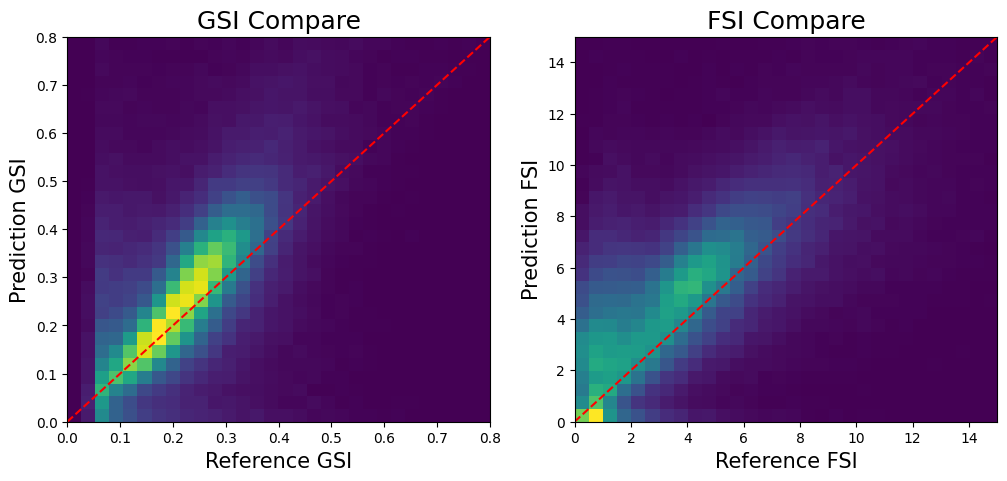

In [13]:
block_df_merged = block_metric_all
block_df_merged = block_df_merged[block_df_merged["refer_GSI"] > 0.05]

plot_GSI_FSI_heatmap(block_df_merged.refer_GSI,block_df_merged.building_2019_GSI_avg,block_df_merged.refer_FSI,block_df_merged.building_2019_FSI_avg,GSI_max = 0.8,FSI_max = 15,bin_heat = 30)

### calculate k-mean on all cities

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# define which year to use as base
building_metric_df = block_cluster_list[-1]

building_metric_df = building_metric_df.fillna(0)
building_metric_df = building_metric_df[building_metric_df["building_GSI"]>0.05]
building_metric_df["huge_block"] = 0
building_metric_df.loc[building_metric_df["Shape_Area"]> 10000,"huge_block"] = 1
building_metric_df["mean_height"] = building_metric_df["building_FSI"]/building_metric_df["building_GSI"]


In [15]:
# normalization
print(building_metric_df["building_GSI"].max())
print(building_metric_df["building_FSI"].max())
print(building_metric_df["mean_height"].max())

building_metric_df["building_FSI_normalized"] = building_metric_df["building_FSI"]/building_metric_df["building_FSI"].max()
building_metric_df["mean_height_normalized"] = building_metric_df["mean_height"]/building_metric_df["mean_height"].max()
building_metric_df["Shape_Area_normalized"] = building_metric_df["Shape_Area"]/building_metric_df["Shape_Area"].max()

1.0
38.556994818652846
99.84556962025317


In [16]:
kmeans = KMeans(n_clusters=7, random_state=48)
#kmeans.fit(building_metric_df[["building_FSI_normalized","building_GSI","mean_height_normalized","huge_block"]])
kmeans.fit(building_metric_df[["building_FSI_normalized","building_GSI","mean_height_normalized","Shape_Area_normalized"]])

#kmeans.fit(building_metric_df[["building_FSI_normalized","building_GSI","huge_block"]])

/data-nfs/mujiang/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7, random_state=48)

In [17]:
building_metric_df['cluster'] = kmeans.labels_
building_metric_gdf = gpd.GeoDataFrame(building_metric_df, geometry=building_metric_df['geometry'])

<function matplotlib.pyplot.show(close=None, block=None)>

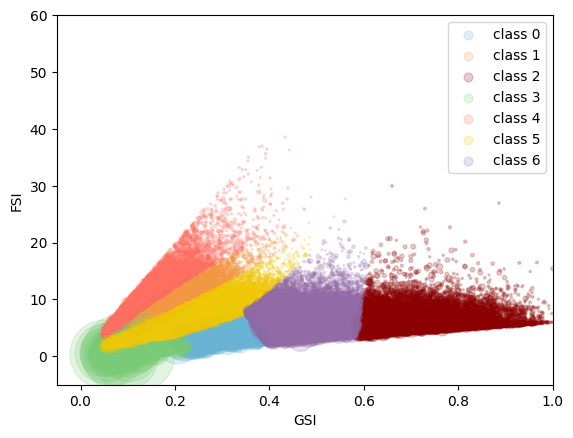

In [18]:
colors = ['#68B3D4',"#F29844",  '#8B0000', '#7ACB77',"#FF6F61" ,'#F0C808','#926AA6']  # Blue, Green, Gold, Red, 
cluster_colors = [colors[int(cluster)] for cluster in building_metric_df["cluster"]]

for i in range(len(colors)):
    plot_df = building_metric_df[building_metric_df["cluster"] == i]
    plt.scatter(plot_df.building_GSI, plot_df.building_FSI,alpha = 0.2,s=10*plot_df["Shape_Area"]/plot_df["Shape_Area"].mean(),c=colors[i],label=f"class {i}" )
plt.xlabel("GSI")
plt.ylabel("FSI")

plt.ylim(-5, 60)
plt.xlim(-0.05, 1)

# Create legend
legend = plt.legend()
legend_handles = legend.legend_handles

# Set the marker size for each handle
marker_size = 40  # Change this value as needed
for handle in legend_handles:
    handle._sizes = [marker_size]

plt.show


/tmp/ipykernel_1131583/1078768794.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(x, y, z, c=colors, s=sizes, cmap=colors, alpha=0.6, edgecolors='w', linewidth=0.5)
/tmp/ipykernel_1131583/1078768794.py:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 13


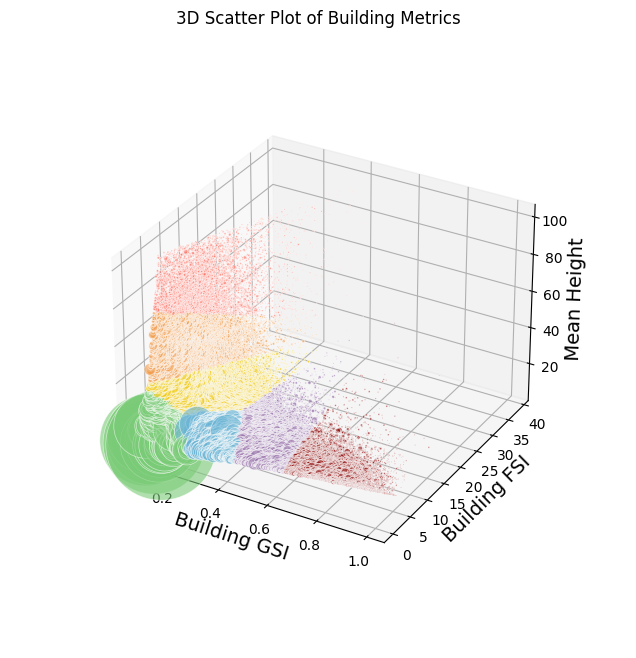

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming building_metric_df is already loaded and ready to use

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

color_list = ['#68B3D4',"#F29844",  '#8B0000', '#7ACB77',"#FF6F61" ,'#F0C808','#926AA6'] # Blue, Green, Gold, Red, 
colors = [color_list[int(i) % len(color_list)] for i in building_metric_df['cluster']]

# Extracting data
x = building_metric_df['building_GSI']
y = building_metric_df['building_FSI']
z = building_metric_df['mean_height']
sizes = building_metric_df['Shape_Area']/50000

# Creating the scatter plot
sc = ax.scatter(x, y, z, c=colors, s=sizes, cmap=colors, alpha=0.6, edgecolors='w', linewidth=0.5)
ax.dist = 13

# Adding labels and title
ax.set_xlabel('Building GSI',fontsize = 14)
ax.set_ylabel('Building FSI',fontsize = 14)
ax.set_zlabel('Mean Height',fontsize = 14)
ax.set_title('3D Scatter Plot of Building Metrics')


# Show plot
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

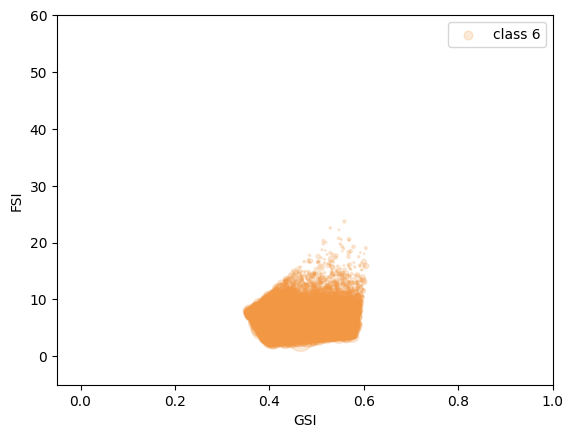

In [20]:
colors = ['#68B3D4','#F0C808', '#D9598C', '#7ACB77',"#FF6F61","#926AA6","#F29844" ,"#F23644"]  # Blue, Green, Gold, Red, 
cluster_colors = [colors[int(cluster)] for cluster in building_metric_df["cluster"]]


i = 6
plot_df = building_metric_df[building_metric_df["cluster"] == i]
plt.scatter(plot_df.building_GSI, plot_df.building_FSI,alpha = 0.2,s=10*plot_df["Shape_Area"]/plot_df["Shape_Area"].mean(),c=colors[i],label=f"class {i}" )
plt.xlabel("GSI")
plt.ylabel("FSI")

plt.ylim(-5, 60)
plt.xlim(-0.05, 1)

# Create legend
legend = plt.legend()
legend_handles = legend.legend_handles

# Set the marker size for each handle
marker_size = 40  # Change this value as needed
for handle in legend_handles:
    handle._sizes = [marker_size]

plt.show

### apply the k-mean model to individual city

In [21]:
def clsuter_predict(building_metric_df,kmean_model):
    building_metric_df = building_metric_df.fillna(0)    
    building_metric_df["huge_block"] = 0
    building_metric_df.loc[building_metric_df["Shape_Area"]> 10000,"huge_block"] = 1
    building_metric_df["mean_height"] = building_metric_df["building_FSI"]/building_metric_df["building_GSI"]
    
    building_metric_df["building_FSI_normalized"] = building_metric_df["building_FSI"]/building_metric_df["building_FSI"].max()
    building_metric_df["mean_height_normalized"] = building_metric_df["mean_height"]/building_metric_df["mean_height"].max()
    building_metric_df["Shape_Area_normalized"] = building_metric_df["Shape_Area"]/building_metric_df["Shape_Area"].max()
    
    df_input = building_metric_df[["building_FSI_normalized","building_GSI","mean_height_normalized","Shape_Area_normalized"]]
    df_input.fillna(0, inplace=True)
    
    result = kmeans.predict(df_input)
    
    return result

### cluster on avg data

In [23]:
# list of result gdf [city][year]
block_cluster_city_list_all = []
# list of years [city][year]
block_cluster_city_year_list_all = []
# list of cluster result accross years for a city [city]
block_cluster_city_result_df_list = []
# list of cluster result counts ccross years for a city [city]
cluster_count_df_list = []

for city in tqdm(pred_city_list):
    city_id = pred_city_list.index(city)
    # read in the block result for selected city
    block_metric = block_metric_list[city_id]
    
    # filter only when building exist across year
    block_metric_city = block_metric[block_metric["building_GSI_max"]>0.05]
    block_metric_unbuilt = block_metric[~(block_metric["building_GSI_max"] > 0.05)]
    
    # every year the clustered result
    block_cluster_city_list = []
    block_cluster_unbuilt_list = []
    block_cluster_city_year_list = []
    

    for year in range(2016,2023):
        # prepare the input data
        if (f'building_{str(year)}_FSI_avg') in block_metric_city.columns:
            block_cluster_df = pd.DataFrame({'block_id': block_metric_city['block_id']})
            block_cluster_df['Shape_Area'] =block_metric_city['Shape_Area']
            block_cluster_df['building_FSI'] = block_metric_city[f'building_{str(year)}_FSI_avg']
            block_cluster_df['building_GSI'] = block_metric_city[f'building_{str(year)}_GSI_avg']
            block_cluster_df['geometry'] = block_metric_city['geometry']

            block_cluster_unbuilt_df = pd.DataFrame({'block_id': block_metric_unbuilt['block_id']})
            block_cluster_unbuilt_df['Shape_Area'] =block_metric_unbuilt['Shape_Area']
            block_cluster_unbuilt_df['building_FSI'] = block_metric_unbuilt[f'building_{str(year)}_FSI_avg']
            block_cluster_unbuilt_df['building_GSI'] = block_metric_unbuilt[f'building_{str(year)}_GSI_avg']
            block_cluster_unbuilt_df['geometry'] = block_metric_unbuilt['geometry']
            block_cluster_unbuilt_df['cluster'] = -1
            
            
            block_cluster_city_year_list.append(year)
            block_cluster_city_list.append(block_cluster_df)
            block_cluster_unbuilt_list.append(block_cluster_unbuilt_df)
    
    # get the predicted cluster labels for each year and merge into a single df: block_cluster_city_result_df       
    block_cluster_city_result_df = pd.DataFrame({'block_id': block_cluster_city_list[0]['block_id']})
    for i in range(len(block_cluster_city_year_list)):
        year = block_cluster_city_year_list[i]
        block_cluster_city = block_cluster_city_list[i]
        block_cluster_city_result_df[f"c_{year}"] = clsuter_predict(block_cluster_city,kmeans)
        
    # assign back the cluster label to each year, concat the non-building part, and turn into gdf
    for i in range(len(block_cluster_city_list)):
        year = block_cluster_city_year_list[i]
        block_cluster_city_list[i]["cluster"] = block_cluster_city_result_df[f"c_{year}"]
        # concat the unbuilt part
        block_cluster_city_list[i] = pd.concat([block_cluster_city_list[i],block_cluster_unbuilt_list[i]], ignore_index=True)
        # sort and drop dupilicate
        block_cluster_city_list[i] = block_cluster_city_list[i].sort_values(by='cluster', ascending=False)
        block_cluster_city_list[i] = block_cluster_city_list[i].drop_duplicates(subset='block_id', keep='first')
        # rename the column
        block_cluster_city_list[i] = block_cluster_city_list[i].rename(columns={"building_FSI": "FSI", "building_GSI": "GSI","Shape_Area": "area"})
        # make labels of unbilt area at that year - 1
        block_cluster_city_list[i].loc[block_cluster_city_list[i]['GSI'] <= 0.05, 'cluster'] = -1
        # turn into gdf
        block_cluster_city_list[i] = gpd.GeoDataFrame(block_cluster_city_list[i], geometry=block_cluster_city_list[i]['geometry'])
        

    # count
    cluster_count_df = pd.DataFrame()
    for year in block_cluster_city_year_list:
        cluster_count_df[f"c_{year}"] = block_cluster_city_result_df[f'c_{year}'].value_counts().sort_index()
        # rename index
        cluster_count_df.rename_axis('cluster', inplace=True)
    
    block_cluster_city_list_all.append(block_cluster_city_list)
    block_cluster_city_year_list_all.append(block_cluster_city_year_list)
    block_cluster_city_result_df_list.append(block_cluster_city_result_df)
    cluster_count_df_list.append(cluster_count_df)
    

    

  0%|                                                                                                                                                                                  | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 10%|█████████████████                                                                                                                                                         | 4/40 [00:00<00:02, 13.60it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 13/40 [00:01<00:01, 14.05it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 21/40 [00:01<00:01, 13.13it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is tr

/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is tr

/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is tr

/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is tr

### save for individual city

In [8]:
block_categorized_savepath = "/data-sat-img/RAW/Block/result/block_categorized/"

In [324]:
for city in pred_city_list:
    print(city)
    city_id = pred_city_list.index(city)
    year_list = block_cluster_city_year_list_all[city_id]    
    
    for year_id in range(len(year_list)):
        year = year_list[year_id]        
        block_categorized_gdf_city = block_cluster_city_list_all[city_id][year_id]
        block_categorized_path = os.path.join(block_categorized_savepath,city,f"{city}-{year}-block_categorized.shp")

        if not os.path.exists(os.path.join(block_categorized_savepath,city)):
            os.mkdir(os.path.join(block_categorized_savepath,city))
            
        if not os.path.exists(block_categorized_path):
            block_categorized_gdf_city.to_file(block_categorized_path) 


Shanghai
Guiyang
Wuxi
Xiamen
Shaoxing
Shenzhen
Harbin
Foshan
Zhongshan
Dongguan
Nanchang
Baoding
Yangzhou
Zhuhai
Chongqing
Chengdu
Suzhou
Zhengzhou
Guangzhou
Beijing
Taiyuan
Sanya
Shenyang
Tianjin
Dalian
Huizhou
Langfang
Fuzhou
Xi_an
Qingdao
Hangzhou
Changsha
Nanjing
Hefei
Ningbo
Zhenjiang
Kunming
Xuzhou
Nanning
Wuhan


### cluster on og data

In [30]:
# list of result gdf [city][year]
block_cluster_city_list_all = []
# list of years [city][year]
block_cluster_city_year_list_all = []
# list of cluster result accross years for a city [city]
block_cluster_city_result_df_list = []
# list of cluster result counts ccross years for a city [city]
cluster_count_df_list = []

for city in tqdm(pred_city_list):
    city_id = pred_city_list.index(city)
    # read in the block result for selected city
    block_metric = block_metric_list[city_id]
    
    # filter only when building exist across year
    block_metric_city = block_metric[block_metric["building_GSI_max"]>0.05]
    block_metric_unbuilt = block_metric[~(block_metric["building_GSI_max"] > 0.05)]
    
    # every year the clustered result
    block_cluster_city_list = []
    block_cluster_unbuilt_list = []
    block_cluster_city_year_list = []
    

    for year in range(2016,2023):
        # prepare the input data
        if (f'building_{str(year)}_FSI') in block_metric_city.columns:
            block_cluster_df = pd.DataFrame({'block_id': block_metric_city['block_id']})
            block_cluster_df['Shape_Area'] =block_metric_city['Shape_Area']
            block_cluster_df['building_FSI'] = block_metric_city[f'building_{str(year)}_FSI']
            block_cluster_df['building_GSI'] = block_metric_city[f'building_{str(year)}_GSI']
            block_cluster_df['geometry'] = block_metric_city['geometry']

            block_cluster_unbuilt_df = pd.DataFrame({'block_id': block_metric_unbuilt['block_id']})
            block_cluster_unbuilt_df['Shape_Area'] =block_metric_unbuilt['Shape_Area']
            block_cluster_unbuilt_df['building_FSI'] = block_metric_unbuilt[f'building_{str(year)}_FSI']
            block_cluster_unbuilt_df['building_GSI'] = block_metric_unbuilt[f'building_{str(year)}_GSI']
            block_cluster_unbuilt_df['geometry'] = block_metric_unbuilt['geometry']
            block_cluster_unbuilt_df['cluster'] = -1
            
            
            block_cluster_city_year_list.append(year)
            block_cluster_city_list.append(block_cluster_df)
            block_cluster_unbuilt_list.append(block_cluster_unbuilt_df)
    
    # get the predicted cluster labels for each year and merge into a single df: block_cluster_city_result_df       
    block_cluster_city_result_df = pd.DataFrame({'block_id': block_cluster_city_list[0]['block_id']})
    for i in range(len(block_cluster_city_year_list)):
        year = block_cluster_city_year_list[i]
        block_cluster_city = block_cluster_city_list[i]
        block_cluster_city_result_df[f"c_{year}"] = clsuter_predict(block_cluster_city,kmeans)
        
    # assign back the cluster label to each year, concat the non-building part, and turn into gdf
    for i in range(len(block_cluster_city_list)):
        year = block_cluster_city_year_list[i]
        block_cluster_city_list[i]["cluster"] = block_cluster_city_result_df[f"c_{year}"]
        # concat the unbuilt part
        block_cluster_city_list[i] = pd.concat([block_cluster_city_list[i],block_cluster_unbuilt_list[i]], ignore_index=True)
        # sort and drop dupilicate
        block_cluster_city_list[i] = block_cluster_city_list[i].sort_values(by='cluster', ascending=False)
        block_cluster_city_list[i] = block_cluster_city_list[i].drop_duplicates(subset='block_id', keep='first')
        # rename the column
        block_cluster_city_list[i] = block_cluster_city_list[i].rename(columns={"building_FSI": "FSI", "building_GSI": "GSI","Shape_Area": "area"})
        # make labels of unbilt area at that year - 1
        block_cluster_city_list[i].loc[block_cluster_city_list[i]['GSI'] <= 0.05, 'cluster'] = -1
        # turn into gdf
        block_cluster_city_list[i] = gpd.GeoDataFrame(block_cluster_city_list[i], geometry=block_cluster_city_list[i]['geometry'])
        

    # count
    cluster_count_df = pd.DataFrame()
    for year in block_cluster_city_year_list:
        cluster_count_df[f"c_{year}"] = block_cluster_city_result_df[f'c_{year}'].value_counts().sort_index()
        # rename index
        cluster_count_df.rename_axis('cluster', inplace=True)
    
    block_cluster_city_list_all.append(block_cluster_city_list)
    block_cluster_city_year_list_all.append(block_cluster_city_year_list)
    block_cluster_city_result_df_list.append(block_cluster_city_result_df)
    cluster_count_df_list.append(cluster_count_df)
    

    

  0%|                                                                                                                                                                                  | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
 12%|█████████████████████▎                                                                                                                                                    | 5/40 [00:00<00:02, 15.14it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 22%|██████████████████████████████████████▎                                                                                                                                   | 9/40 [00:00<00:02, 14.23it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is tr

 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 18/40 [00:01<00:01, 15.11it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 22/40 [00:01<00:01, 14.64it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 27/40 [00:01<00:00, 15.91it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 35/40 [00:02<00:00, 15.22it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 39/40 [00:02<00:00, 16.25it/s]/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.fillna(0, inplace=True)
/tmp/ipykernel_1131583/2107093435.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

### visualization

In [35]:
city = 'Baoding'
city_id = pred_city_list.index(city)
plot_year = 2019
year_id = block_cluster_city_year_list_all[city_id].index(plot_year)
plot_df_city = block_cluster_city_list_all[city_id][year_id]

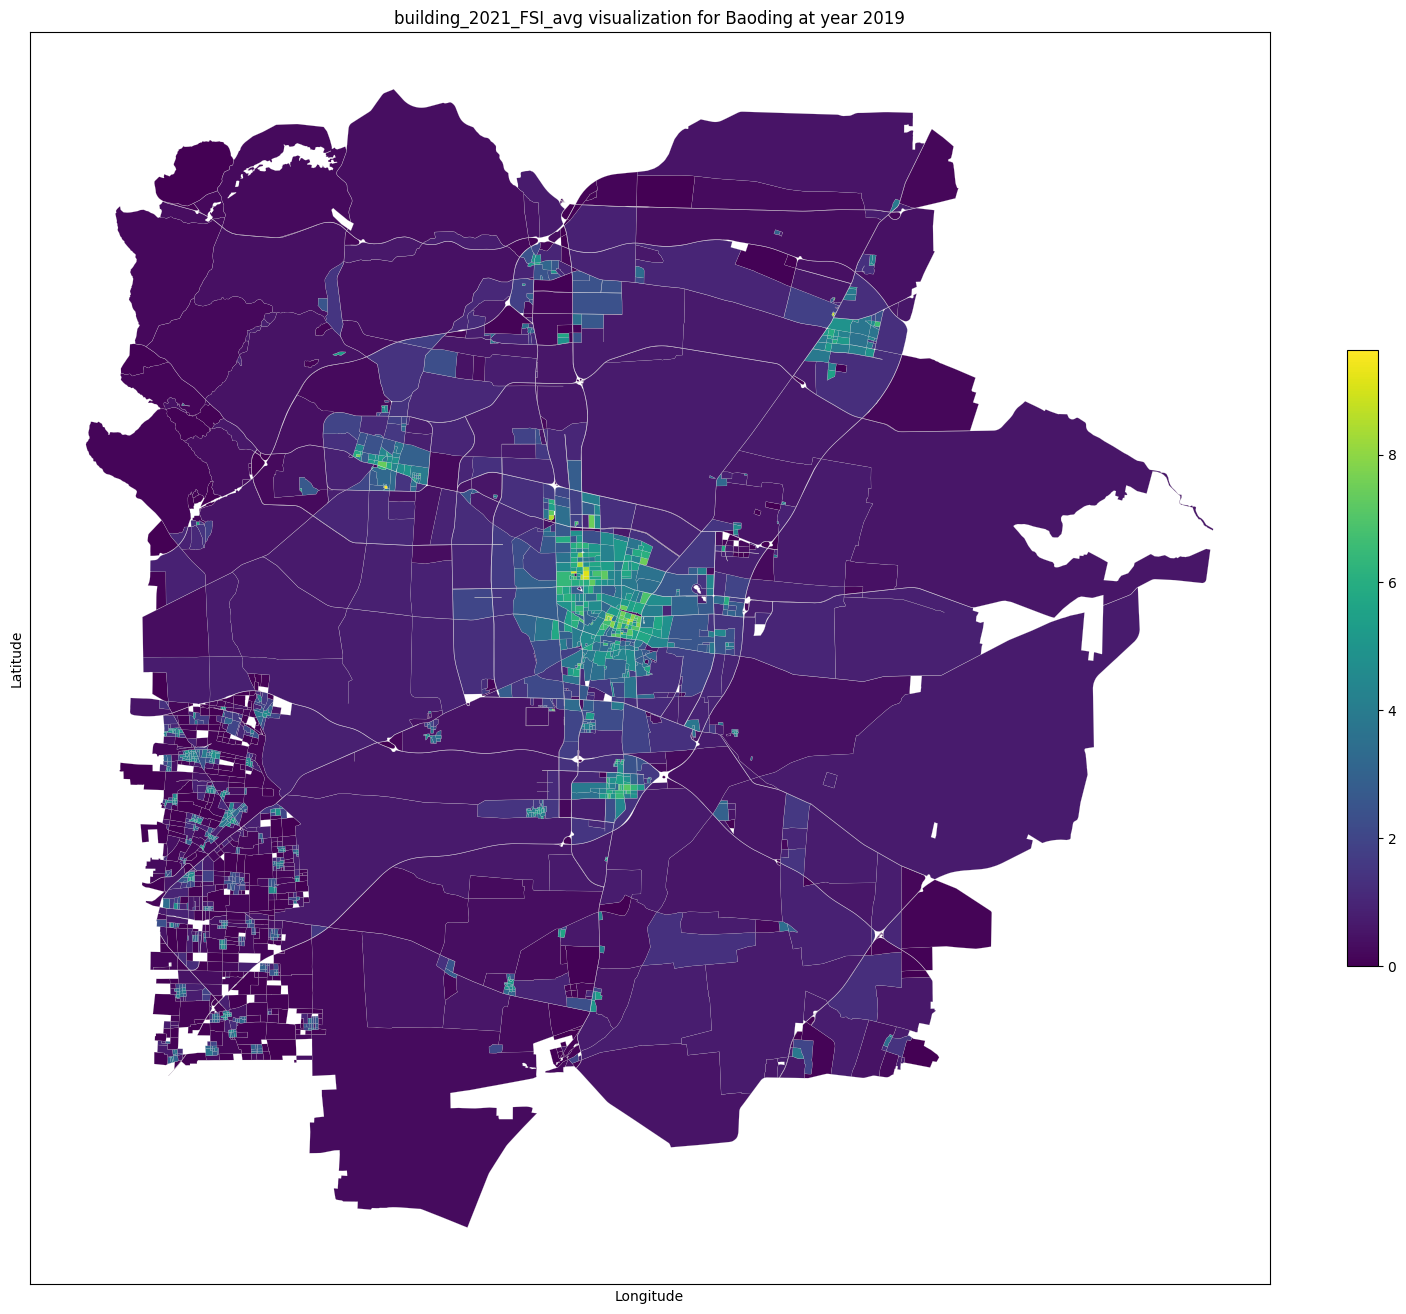

In [36]:
# Custom color list
from matplotlib.colors import ListedColormap

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot the GeoDataFrame
# 'column' specifies the column used for coloring, 'cmap' is the colormap
plot = block_metric_list[city_id].plot(column='building_2021_FSI_avg', cmap='viridis', linewidth=0.1, ax=ax, edgecolor='0.8')

# Adding a colorbar
fig.colorbar(plot.collections[0], ax=ax, orientation='vertical', shrink=0.4)

# Adding title and labels (optional)
ax.set_title(f'building_2021_FSI_avg visualization for {city} at year {plot_year}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove x and y axis for a cleaner look (optional)
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [37]:
plot_df_city.head()

,block_id,area,FSI,GSI,geometry,cluster
949,11660,25453.265754,3.284946,0.547491,"POLYGON ((12853756.353 4693933.325, 12853718.9...",6
414,9908,220574.071109,2.752095,0.425349,"POLYGON ((12822010.227 4681756.041, 12822073.2...",6
782,11097,18790.732684,6.240920,0.369249,"POLYGON ((12855667.141 4690694.029, 12855655.0...",6
407,9889,164147.125046,3.007094,0.501182,"POLYGON ((12828678.465 4681005.728, 12828524.0...",6
408,9890,170687.579464,2.816296,0.466685,"POLYGON ((12828950.095 4681690.208, 12828953.9...",6


<function matplotlib.pyplot.show(close=None, block=None)>

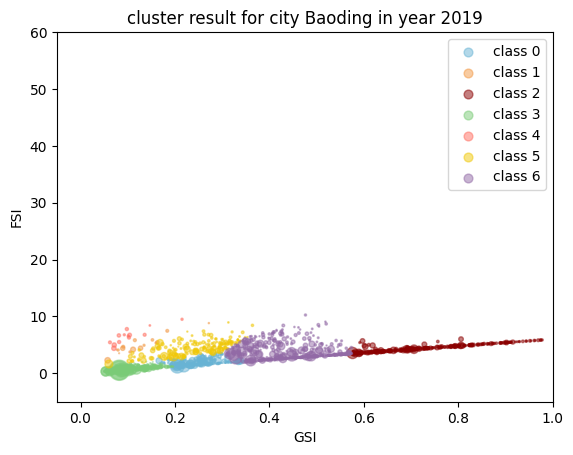

In [38]:
colors = ['#68B3D4',"#F29844",  '#8B0000', '#7ACB77',"#FF6F61" ,'#F0C808','#926AA6']  # Blue, Green, Gold, Red, 
cluster_colors = [colors[int(cluster)] for cluster in building_metric_df["cluster"]]

for i in range(len(colors)):
    plot_df = plot_df_city[plot_df_city["cluster"] == i]
    plt.scatter(plot_df.GSI, plot_df.FSI,alpha = 0.5,s=5*plot_df["area"].astype("float32")/plot_df["area"].astype("float32").mean(),c=colors[i],label=f"class {i}" )
plt.xlabel("GSI")
plt.ylabel("FSI")

plt.ylim(-5, 60)
plt.xlim(-0.05, 1)

# Create legend
legend = plt.legend()
legend_handles = legend.legend_handles

# Set the marker size for each handle
marker_size = 40  # Change this value as needed
for handle in legend_handles:
    handle._sizes = [marker_size]

plt.title(f'cluster result for city {city} in year {plot_year}')
    
plt.show

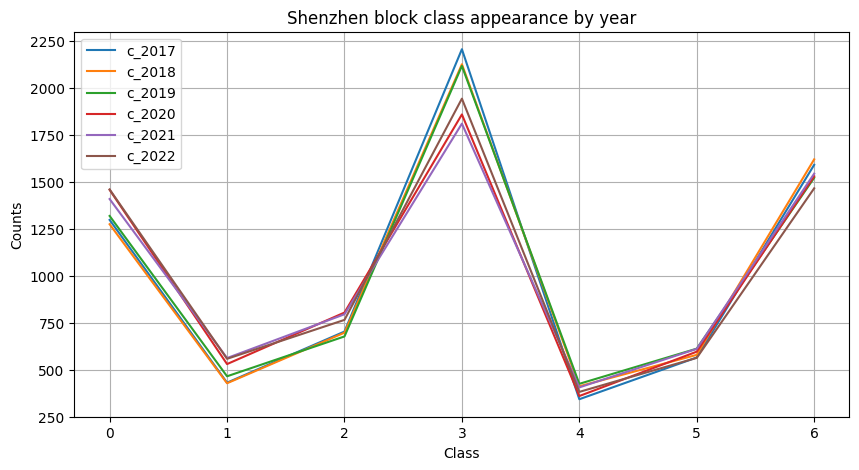

In [389]:
# Plotting the data
cluster_count_df = cluster_count_df_list[city_id]
cluster_count_df.plot(kind='line', figsize=(10, 5))
plt.xlabel('Class')
plt.ylabel('Counts')
plt.title(f'{city} block class appearance by year')
plt.grid(True)
plt.show()

In [371]:
# Custom color list
from matplotlib.colors import ListedColormap

colors = ['#D3D3D3','#68B3D4',"#F29844",  '#8B0000', '#7ACB77',"#FF6F61" ,'#F0C808','#926AA6']
cmap = ListedColormap(colors)

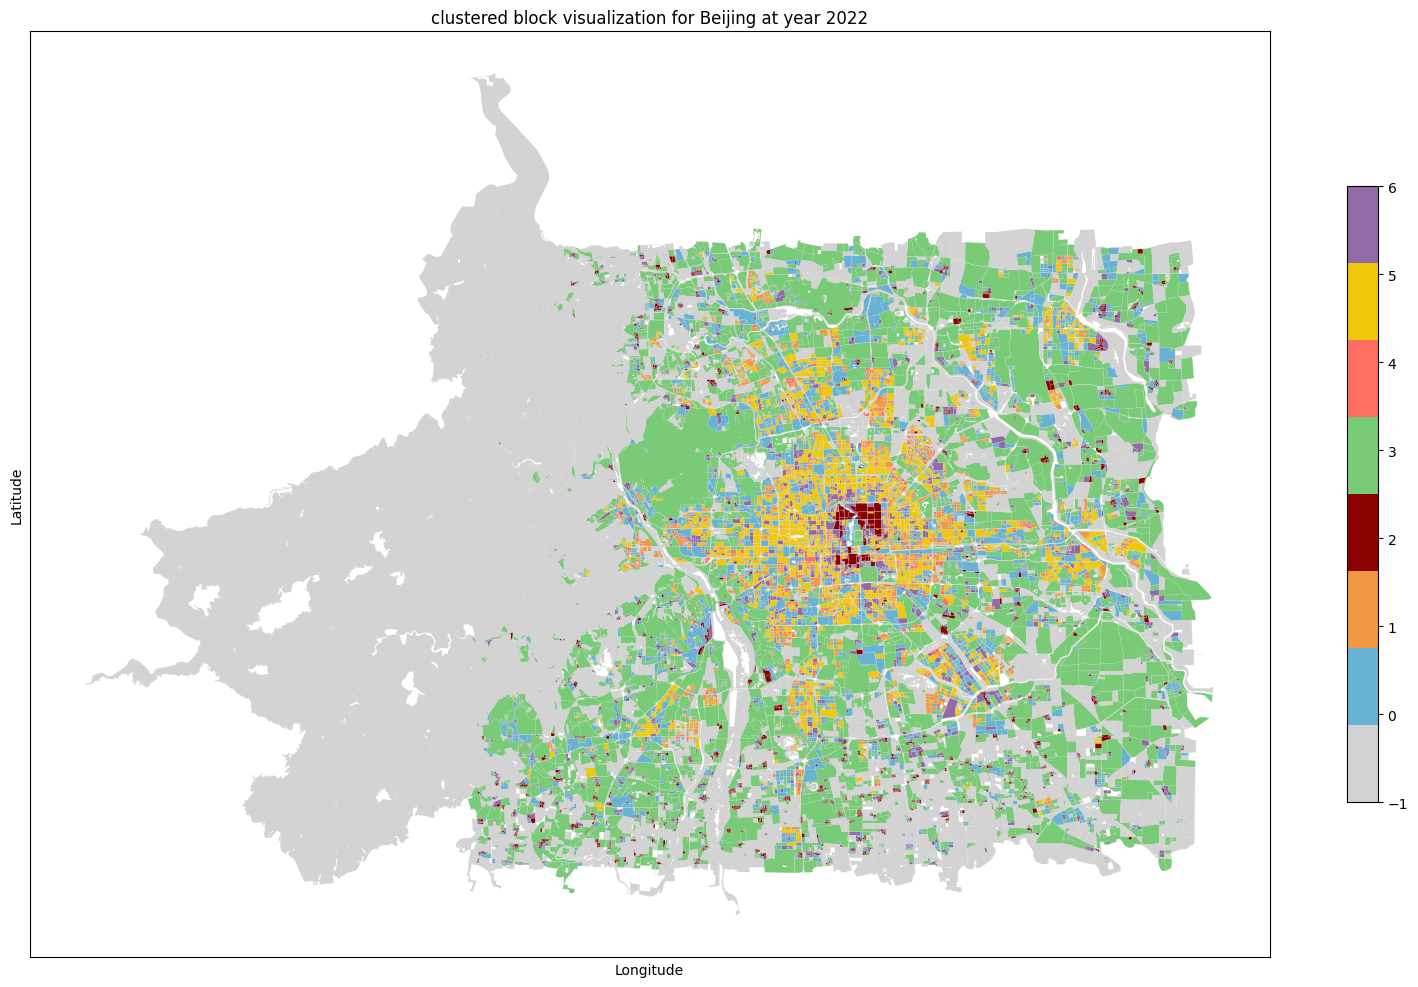

In [382]:
# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot the GeoDataFrame
# 'column' specifies the column used for coloring, 'cmap' is the colormap
plot = plot_df_city.plot(column='cluster', cmap=cmap, linewidth=0.1, ax=ax, edgecolor='0.8')

# Adding a colorbar
fig.colorbar(plot.collections[0], ax=ax, orientation='vertical', shrink=0.4)

# Adding title and labels (optional)
ax.set_title(f'clustered block visualization for {city} at year {plot_year}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove x and y axis for a cleaner look (optional)
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

### comparsion between cities

In [332]:
selected_pred_city_list = ["Beijing","Shanghai","Shenzhen","Guangzhou"]

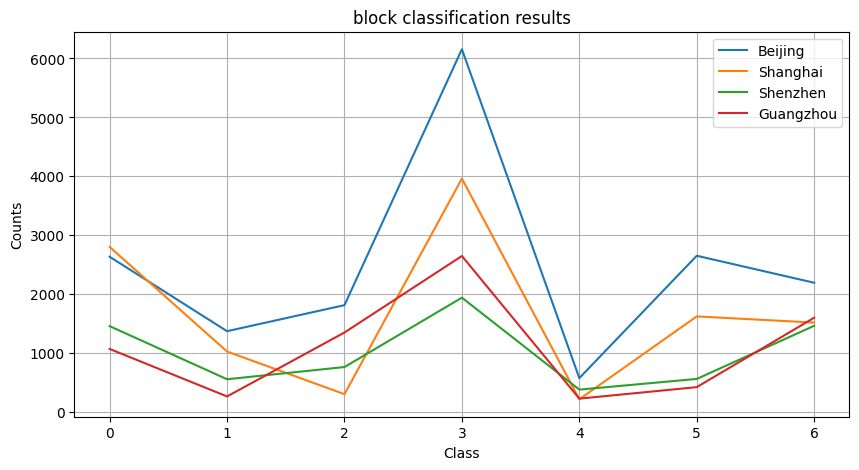

In [384]:
# Plotting the data
for city in selected_pred_city_list:
    city_id = pred_city_list.index(city)
    cluster_count_df = cluster_count_df_list[city_id]
    cluster_count_df.iloc[:,-1].plot(kind='line', figsize=(10, 5),label = city)


plt.xlabel('Class')
plt.ylabel('Counts')
plt.title(f'block classification results')
plt.grid(True)
plt.legend()
plt.show()

# accessbility

### download the OSM road network graph

In [ ]:
city_list = []

In [29]:
city = "Shenzhen"
print(city)

Shenzhen


In [9]:
pred_city_list = ["Fuzhou"]

In [11]:
osmnx_graph_path = "/data-sat-img/postprocessed/mujiang/master-thesis/osmnx_graph/"

### download data 
for city in pred_city_list:
    osmnx_graph_graphml = os.path.join(osmnx_graph_path,f'{city}_graph.graphml')
    osmnx_graph_gpkg = os.path.join(osmnx_graph_path,f'{city}_graph.gpkg')
    
    if not os.path.exists(osmnx_graph_gpkg):
        print(city)
        print("start downloading graph from OSM")
        graph = ox.graph_from_place(f'{city}, Fujian, China', network_type='all')
        print("save downloaded graph as graphml format")
        ox.save_graphml(graph, filepath=osmnx_graph_graphml)
        print("save downloaded graph as gpkg format")
        ox.io.save_graph_geopackage(graph, filepath=osmnx_graph_gpkg, encoding='utf-8', directed=False)

Fuzhou
start downloading graph from OSM
save downloaded graph as graphml format
save downloaded graph as gpkg format


In [30]:

# Save the graph to a GraphML file

#  the graph to a geopackage file


### modify the geopackage to build linkage to blocks

In [70]:


# Save the graph to roads and nodes
ox.save_graphml(graph, filepath=os.path.join(osmnx_graph_path,f'{city}_graph.graphml'))

In [31]:
# load the graph
graph = ox.load_graphml(os.path.join(osmnx_graph_path,f'{city}_graph.graphml'))

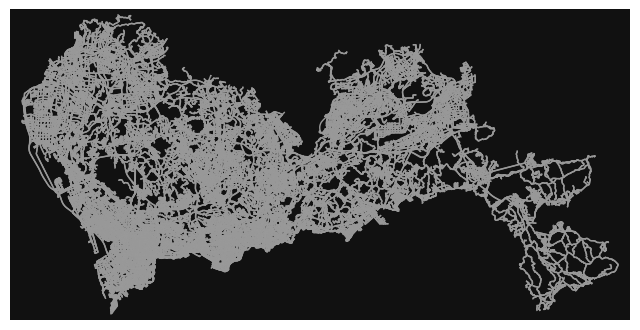

In [72]:
# Configure the inline display of plots from matplotlib
%matplotlib inline

# Plot the graph
fig, ax = ox.plot_graph(graph, node_size=0)

## important assumption: now only the centroid of blocks are used to find the nearest node in the network, which also takes most of the time. so consider pre-creation of the access points of the block, maybe from point? and instead of creating a convex hull, just find directly the accessible poi is better

In [84]:
block_plot_gdf.shape
block_plot_gdf = block_plot_gdf.to_crs('epsg:4326')

In [140]:
# Function to calculate catchment area
def calculate_catchment_area(block, graph, distance=500):
    start_time = time.time()
    
    # Find nearest node to building on the network
    nearest_node = ox.distance.nearest_nodes(graph, block.centroid.x, block.centroid.y)
    print("the nearest node is:",nearest_node)
    time_nearest_node = time.time()
    print(f"Time to find nearest node: {time_nearest_node - start_time:.2f} seconds")
    
    
    # Compute the subgraph reachable within 500 meters
    subgraph = nx.ego_graph(graph, nearest_node, radius=distance, distance='length')
    nodes = subgraph.nodes(data=True)
    time_subgraph = time.time()
    print(f"Time to compute subgraph: {time_subgraph - time_nearest_node:.2f} seconds")
    
    # Create a GeoDataFrame from the nodes
    data = [{'osmid': node[0], 'x': node[1]['x'], 'y': node[1]['y'], 'geometry': Point(node[1]['x'], node[1]['y'])} for node in nodes]
    gdf_nodes = gpd.GeoDataFrame(data, geometry='geometry')
    time_gdf_creation = time.time()
    print(f"Time to create GeoDataFrame: {time_gdf_creation - time_subgraph:.2f} seconds")
    
    # Create a convex hull or buffer around the points
    catchment_area = gdf_nodes.unary_union.convex_hull
    time_convex_hull = time.time()
    print(f"Time to compute convex hull: {time_convex_hull - time_gdf_creation:.2f} seconds")
    print(f"Total time: {time_convex_hull - start_time:.2f} seconds")    
    print("the catchment area is",catchment_area.area)
    
    return catchment_area

# Apply to all blocks
block_plot_gdf['catchment_area'] = block_plot_gdf["geometry"].apply(lambda x: calculate_catchment_area(x, graph))

the nearest node is: 5843414467
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.17 seconds
the catchment area is 1.0282042644990872e-05
the nearest node is: 9863118003
Time to find nearest node: 1.87 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 1.88 seconds
the catchment area is 1.117840290997881e-05
the nearest node is: 5999844076
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 1.123507972499199e-05
the nearest node is: 1169601098
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 

the nearest node is: 8391114092
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 8.527768469999128e-06
the nearest node is: 9863118213
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 3.951113090001752e-06
the nearest node is: 1169605648
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.17 seconds
the catchment area is 3.446169111000531e-05
the nearest node is: 6728676910
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0

the nearest node is: 2531769990
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.17 seconds
the catchment area is 2.1056277604983397e-05
the nearest node is: 8391043073
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 1.4531191034981102e-05
the nearest node is: 5865250202
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 2.8825286660029077e-05
the nearest node is: 2531767581
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time

the nearest node is: 9863118376
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 7.211674480024941e-06
the nearest node is: 5865250275
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 0.16 seconds
the catchment area is 1.8439056405015137e-05
the nearest node is: 2531767572
Time to find nearest node: 1.84 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 1.84 seconds
the catchment area is 2.825615036496432e-05
the nearest node is: 2531767622
Time to find nearest node: 0.16 seconds
Time to compute subgraph: 0.00 seconds
Time to create GeoDataFrame: 0.00 seconds
Time to compute convex hull: 0.00 seconds
Total time: 

KeyboardInterrupt: 

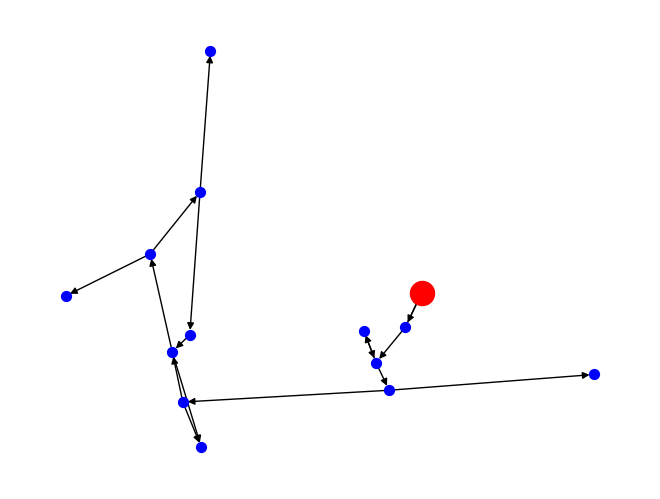

In [136]:
# Create ego graph of main hub
hub_ego = nx.ego_graph(graph, 9737787887, radius=500, distance='length')

# Draw graph
pos = nx.spring_layout(hub_ego, seed=0)  # Seed layout for reproducibility
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[9737787887], **options)
plt.show()

In [110]:
block_catchment_gdf

,block_id,block_area,building_FSI,building_GSI,geometry,cluster,catchment_area,catchment
1,3,3376,3.866904,0.416124,"POLYGON ((113.89372 22.46928, 113.89254 22.469...",1,0.000010,"POLYGON ((113.89257 22.46892, 113.89085 22.470..."
2,4,11779,3.737442,0.463226,"POLYGON ((113.89078 22.46866, 113.89068 22.468...",1,0.000011,"POLYGON ((113.89151 22.46883, 113.89061 22.469..."
3,7,2336,1.974529,0.273330,"POLYGON ((113.88911 22.47414, 113.88897 22.474...",0,0.000011,"POLYGON ((113.88897 22.47407, 113.88814 22.474..."
9,17,657,3.122527,0.275495,"POLYGON ((113.90410 22.47945, 113.90409 22.479...",0,0.000010,"POLYGON ((113.90108 22.47784, 113.89931 22.480..."
10,18,1326,1.044495,0.131222,"POLYGON ((113.89953 22.48090, 113.90184 22.478...",3,0.000004,"POLYGON ((113.90073 22.47817, 113.89844 22.480..."
...,...,...,...,...,...,...,...,...
8063,17349,107755,2.711560,0.271602,"POLYGON ((114.12359 22.71640, 114.12360 22.716...",0,0.000010,"POLYGON ((114.12074 22.70634, 114.11984 22.707..."
8064,17350,122628,1.340685,0.092563,"POLYGON ((114.13897 22.71629, 114.14690 22.698...",3,0.000001,"POLYGON ((114.13692 22.69865, 114.13657 22.700..."
8066,17353,10952,1.291560,0.118091,"POLYGON ((114.13628 22.71545, 114.13565 22.714...",3,0.000002,"POLYGON ((114.13234 22.71121, 114.13167 22.711..."
8067,17354,11241,2.652507,0.209901,"POLYGON ((114.40324 22.71118, 114.40316 22.711...",0,0.000003,"POLYGON ((114.40260 22.71591, 114.40145 22.718..."


In [129]:
### save the catchment result
catchment_path = "/data-sat-img/postprocessed/mujiang/master-thesis/catchment/"

block_catchment_gdf = block_plot_gdf.copy()
block_catchment_gdf.drop(['geometry'], axis=1,inplace=True)

block_catchment_gdf = gpd.GeoDataFrame(block_catchment_gdf, geometry='catchment_area')
block_catchment_gdf= block_catchment_gdf[block_catchment_gdf['catchment_area'].geom_type == 'Polygon']
block_catchment_gdf.to_file(os.path.join(catchment_path,f"catchment_{city}.shp"))  

/tmp/ipykernel_359900/3967355533.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  block_catchment_gdf.to_file(os.path.join(catchment_path,f"catchment_{city}.shp"))


In [126]:
block_plot_gdf

,block_id,block_area,building_FSI,building_GSI,geometry,cluster,catchment_area
1,3,3376,3.866904,0.416124,"POLYGON ((113.89372 22.46928, 113.89254 22.469...",1,"POLYGON ((113.89257 22.46892, 113.89085 22.470..."
2,4,11779,3.737442,0.463226,"POLYGON ((113.89078 22.46866, 113.89068 22.468...",1,"POLYGON ((113.89151 22.46883, 113.89061 22.469..."
3,7,2336,1.974529,0.273330,"POLYGON ((113.88911 22.47414, 113.88897 22.474...",0,"POLYGON ((113.88897 22.47407, 113.88814 22.474..."
5,11,6086,1.543953,0.186220,"POLYGON ((113.90355 22.47745, 113.90352 22.477...",3,"LINESTRING (113.89910 22.47353, 113.90096 22.4..."
9,17,657,3.122527,0.275495,"POLYGON ((113.90410 22.47945, 113.90409 22.479...",0,"POLYGON ((113.90108 22.47784, 113.89931 22.480..."
...,...,...,...,...,...,...,...
8067,17354,11241,2.652507,0.209901,"POLYGON ((114.40324 22.71118, 114.40316 22.711...",0,"POLYGON ((114.40260 22.71591, 114.40145 22.718..."
8069,17360,139164,1.306427,0.144860,"POLYGON ((114.09984 22.73182, 114.09984 22.731...",3,POINT (114.10976 22.71770)
8071,17364,18891,0.901699,0.075874,"POLYGON ((114.20573 22.72756, 114.20569 22.727...",3,POINT (114.21076 22.73354)
8074,17370,163646,1.400821,0.128587,"POLYGON ((114.21347 22.75006, 114.21364 22.750...",3,POINT (114.21867 22.74748)
